# <b>背景</b>

<p>ET（essential tremor）患者：原发性震颤(Essential tremor)患者，特发性震颤（essential tremor，ＥＴ）最常见的运动障碍性疾病，主要为手、头部及身体其他部位的姿位性和运动性震颤。发病部位：上肢、头、面部、下颚。</p>
<p>参见文献： louis2003 Factors associated with increased risk of head tremor in essential tremor_ a community-based study in northern Manhattan）。</p>
<p>中线震颤（midline tremor）：   包含：面部（下颌部+唇部）、舌头、声音、头部（又称颈部）和躯干。<p>

    
# <b>目的</b>
1.1.	探索ET患者伴中线震颤的危险因素。
    
1.2.	ET患者伴焦虑和抑郁的危险因素    
    
# <b>任务</b>

探索ET患者伴中线震颤的危险因素：统计推断（独立性检验）面部（下颌部+唇部）、舌头、声音、头部（又称颈部）、躯干，以及焦虑和抑郁 等的关系（合并、伴发情况）


# <b>第一步 引包</b>

In [24]:
#引包：引入所需python包
import xlrd
import os
import re
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve,auc
import matplotlib as mpl
from matplotlib import pyplot as plt
from numpy import nan
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# <b>第二步 读取清洗后数据</b>

1）设置默认目录

2）读取csv文件；


In [25]:
dir = "./"
print(os.listdir(dir))

['.ipynb_checkpoints', '1.数据读取和清洗.ipynb', 'data', 'output', '2.中线震颤并发情况.ipynb', '3.人口特征统计.ipynb', '4.疾病特征统计.ipynb', '5.变量相关性和重要性.ipynb', '6.危险因子（逻辑回归）.ipynb', 'requirements.txt', 'pip_search_result.txt']


In [26]:
#清洗后数据
df = pd.read_csv(dir+"output/df_clean.csv",index_col=0) #第一列为行索引
#df = df.drop(columns = df.columns[0]) #删除不需要的列
df.head(2)

,编号,性别,工作状态合并栏,婚姻状况合并栏,年龄,发病年龄,主要受累部位=2,总病程,上肢病程,下肢病程,...,声音,颈部,面声颈部位分级分数,面声颈量表分数,面声颈有无,声颈量表部位分级,声颈量表分数,声颈有无,下肢震颤,意向性震颤
0,G001,0,1,1,72,68,0,4.0,4.000,0.001,...,0,0,0,0,0,0,0,0,1,0
1,G002,0,1,1,45,40,1,5.0,0.001,0.001,...,1,1,2,3,1,2,3,1,1,0


In [27]:
#中线震颤数据
midline1 = pd.read_csv(dir+"output/midline1.csv",index_col=0) #第一列为行索引
#midline1 = midline1.drop(columns = midline1.columns[0]) #删除不需要的列
midline1.head(2)

,编号,静止性上肢震颤分数,运动性上肢震颤总分,运动性下肢震颤分数,运动性四肢震颤总分,上肢静止性震颤,下肢静止性震颤,四肢静止性震颤,意向性震颤,面部,...,下肢震颤,抑郁分类,焦虑分类,运动性上肢震颤总分有无,运动性下肢震颤分数有无,运动性四肢震颤总分有无,面声颈部位分级分数有无,面声颈量表分数有无,声颈量表部位分级有无,声颈量表分数有无
0,G001,0,21,6,27,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0
1,G002,0,13,2,15,0,0,0,0,0,...,1,0,0,1,1,1,1,1,1,1


# <b>第三步 准备数据 </b>
根据数据分析任务，处理数据

<b> 1) 筛选数据 </b>

筛选与人口统计有关字段

In [28]:
dem = df.filter(items=["编号","性别",'工作状态合并栏', '婚姻状况合并栏','受教育时间',"婚姻状况","年龄","发病年龄","总病程","上肢病程","下肢病程","颈部病程","声音病程","面部病程","舌病程","躯干病程"])
dem = pd.merge(dem,midline1,on=["编号"] ,how = "left")
dem.head(2)

,编号,性别,工作状态合并栏,婚姻状况合并栏,受教育时间,年龄,发病年龄,总病程,上肢病程,下肢病程,...,下肢震颤,抑郁分类,焦虑分类,运动性上肢震颤总分有无,运动性下肢震颤分数有无,运动性四肢震颤总分有无,面声颈部位分级分数有无,面声颈量表分数有无,声颈量表部位分级有无,声颈量表分数有无
0,G001,0,1,1,6,72,68,4.0,4.000,0.001,...,1,0,0,1,1,1,0,0,0,0
1,G002,0,1,1,16,45,40,5.0,0.001,0.001,...,1,0,0,1,1,1,1,1,1,1


<b> 2) 病程字段保持缺失值 </b>

为了不影响统计，缺失值不处理

In [29]:
for i in ["总病程","上肢病程","下肢病程","颈部病程","声音病程","面部病程","舌病程","躯干病程"]:
     dem.loc[dem[i].isin([0,0.001]),i]= None
dem.head(2)

,编号,性别,工作状态合并栏,婚姻状况合并栏,受教育时间,年龄,发病年龄,总病程,上肢病程,下肢病程,...,下肢震颤,抑郁分类,焦虑分类,运动性上肢震颤总分有无,运动性下肢震颤分数有无,运动性四肢震颤总分有无,面声颈部位分级分数有无,面声颈量表分数有无,声颈量表部位分级有无,声颈量表分数有无
0,G001,0,1,1,6,72,68,4.0,4.0,NaN,...,1,0,0,1,1,1,0,0,0,0
1,G002,0,1,1,16,45,40,5.0,NaN,NaN,...,1,0,0,1,1,1,1,1,1,1


# <b> 第四步 统计描述 </b>

In [30]:
stat_pop = pd.DataFrame()
tremors = ['上肢静止性震颤', '下肢静止性震颤', '四肢静止性震颤','运动性上肢震颤总分有无', '运动性下肢震颤分数有无', '运动性四肢震颤总分有无', '下肢震颤','面部', '声音', '颈部','声颈有无',  '面声颈有无', 
            '抑郁分类', '焦虑分类','意向性震颤' ]
for i in tremors:
    stat_sex = pd.crosstab(dem[i],dem["性别"],margins = True) 
    stat_job = pd.crosstab(dem[i],dem["工作状态合并栏"],margins = True)
    stat_pop1 = stat_sex.join(stat_job,lsuffix = "_性别" ,rsuffix="_工作")
    stat_age = dem.pivot_table(index= i ,columns = ["性别"],values= ["年龄"], aggfunc =np.mean  )    
    stat_pop1 = stat_pop1.join(stat_age,lsuffix = "" ,rsuffix="_年龄")
    stat_marri = pd.crosstab(dem[i],dem["婚姻状况合并栏"],margins = True)
    stat_sex = dem.pivot_table(index= i ,values= ["年龄"],aggfunc =np.mean)
    stat_pop1 = stat_pop1.join(stat_sex,lsuffix = "" ,rsuffix="_年龄")
    
    stat_pop1 = stat_pop1.join(stat_marri,lsuffix = "" ,rsuffix="_婚姻")
    
    stat_sickage = dem.pivot_table(index= i ,values= ["受教育时间"], aggfunc =np.mean  )
    stat_pop1 = stat_pop1.join(stat_sickage,lsuffix = "" ,rsuffix="_受教育时间")
    stat_totalyears = dem.pivot_table(index= i ,values= ["总病程"],aggfunc =np.mean)
    stat_pop1 = stat_pop1.join(stat_totalyears,lsuffix = "" ,rsuffix="_总病程")
    stat_sickyears = dem.pivot_table(index= i ,values=[ "发病年龄","上肢病程","下肢病程","颈部病程","声音病程","面部病程","舌病程","躯干病程"], aggfunc =np.mean  )
    stat_pop1 = stat_pop1.join(stat_sickyears,lsuffix = "" ,rsuffix="_病程")
    stat_pop1 = pd.DataFrame(stat_pop1)
    stat_pop1["症状"] = i
    stat_pop1["type"] = stat_pop1.index
    stat_pop = stat_pop.append(stat_pop1)
stat_pop["症状"] = stat_pop["症状"].apply(lambda x:x.replace("有无", ""))
stat_pop = stat_pop.loc[stat_pop["type"]!="All",:]
aList = ["女性人数","男性人数","总人数","在职人数","无业人数","总人数","女性年龄","男性年龄","平均年龄","已婚人数","未婚人数","总人数"]

aList.extend(list(stat_pop.columns[12:]))
stat_pop.columns = aList
stat_pop.head(5)

,女性人数,男性人数,总人数,在职人数,无业人数,总人数,女性年龄,男性年龄,平均年龄,已婚人数,...,上肢病程,下肢病程,发病年龄,声音病程,舌病程,躯干病程,面部病程,颈部病程,症状,type
0,89,90,179,101,78,179,58.943820,54.255556,56.586592,150,...,8.605750,5.625,47.145251,7.629386,14.083333,NaN,8.433333,6.980303,上肢静止性震颤,0
1,13,8,21,5,16,21,69.307692,75.750000,71.761905,18,...,10.261905,3.300,60.095238,9.750000,NaN,7.0,3.500000,8.375000,上肢静止性震颤,1
0,100,98,198,106,92,198,59.800000,56.010204,57.924242,167,...,8.832018,5.275,48.196970,7.831349,14.083333,7.0,7.611111,7.157407,下肢静止性震颤,0
1,2,0,2,0,2,2,83.500000,NaN,83.500000,1,...,4.500000,1.000,79.000000,NaN,NaN,NaN,NaN,NaN,下肢静止性震颤,1
0,89,90,179,101,78,179,58.943820,54.255556,56.586592,150,...,8.605750,5.625,47.145251,7.629386,14.083333,NaN,8.433333,6.980303,四肢静止性震颤,0


# <b> 第五步 统计推断 </b>

<b> 1) 类别变量的独立性检验 </b>

H0：两变量独立；(p>0.05)    H1：两变量有关（p<0.05)

In [31]:
result  =pd.DataFrame() 
for i in tremors:
    for kk in ["性别","工作状态合并栏","婚姻状况合并栏"]:
        data = pd.crosstab(dem[i],dem[kk],margins = False) 
    #print(data)
        g, p, t,k, = chi2_contingency(data)   #chi2_contingency(data)   #第一个值为卡方值，第二个值为P值，第三个值为自由度，第四个为与原数据数组同维度的对应理论值
        line = [(i,kk,g,p)]   #chisquare(data,axis =None )频数
    #print (line)
        result = result.append(line) #未做“工作状态”的检验，因频数太小，不满足
result.columns = ["病症","因素","卡方统计值","P值"]
result["推断（alpha=0.05检验）"] = [x>0.05 for x in result["P值"]]
result.head(5)

,病症,因素,卡方统计值,P值,推断（alpha=0.05检验）
0,上肢静止性震颤,性别,0.682178,0.408838,True
0,上肢静止性震颤,工作状态合并栏,6.770188,0.009269,False
0,上肢静止性震颤,婚姻状况合并栏,0.007759,0.929808,True
0,下肢静止性震颤,性别,0.465641,0.494999,True
0,下肢静止性震颤,工作状态合并栏,0.635824,0.425227,True


<b> 2)连续变量的Wilcoxon秩和检验 </b>

这是一种非参数检验方法，对数据的正态性和方差齐性没要求。

In [32]:
list1 = ["年龄","受教育时间","发病年龄","总病程","上肢病程","下肢病程","颈部病程","声音病程","面部病程","舌病程","躯干病程"]
result  =pd.DataFrame()
for type in tremors:
    for col in list1 :
        group1 = dem[dem[type] ==0][col]
        group1 = group1[~(group1.isna())]
        group2 = dem[dem[type] ==1][col]
        group2 = group2[~(group2.isna())]
        g,p= mannwhitneyu(group1,group2)
        line = [(type,col,g,p)] 
        result = result.append(line)

result.columns = ["病症","因素","U统计值","p值"] 
result["推断（alpha=0.05检验）"] = [x>0.05 for x in result["p值"]]
result.head(5)

,病症,因素,U统计值,p值,推断（alpha=0.05检验）
0,上肢静止性震颤,年龄,858.5,0.000024,False
0,上肢静止性震颤,受教育时间,1399.0,0.024589,False
0,上肢静止性震颤,发病年龄,1104.5,0.001010,False
0,上肢静止性震颤,总病程,1423.5,0.031868,False
0,上肢静止性震颤,上肢病程,1457.0,0.076192,True


<b> 3）连续变量和类别变量之间的one-way ANOVA test</b>

H0  ： two or more groups have the same population mean

In [33]:
list1 = ["年龄","受教育时间","发病年龄","总病程","上肢病程","下肢病程","颈部病程","声音病程","面部病程","舌病程","躯干病程"]
result = pd.DataFrame()
for type in tremors:
    for col in list1 :
        group1 = dem[dem[type] ==0][col]
        group1 = group1[~(group1.isna())]        
        group2 = dem[dem[type] ==1][col]  
        group2 = group2[~(group2.isna())]
        g,p= stats.f_oneway(group1,group2)
        line = [(type,col,g,p)] 
        result = result.append(line)
        
        #print(type,col,":","stat = ",stat,"p = ：",p)
#中位数，四分位数
result.columns = ["病症","因素","one way anova统计值","p值"] 
# 结果合并
result["推断（alpha=0.05检验）"] = [x>0.05 for x in result["p值"]]
result.head(5)

,病症,因素,one way anova统计值,p值,推断（alpha=0.05检验）
0,上肢静止性震颤,年龄,16.863113,0.000059,False
0,上肢静止性震颤,受教育时间,4.806251,0.029522,False
0,上肢静止性震颤,发病年龄,10.540249,0.001372,False
0,上肢静止性震颤,总病程,1.032227,0.310876,True
0,上肢静止性震颤,上肢病程,0.628734,0.428809,True


# <b>第六步 可视化：热力图 </b>
对统计检验结果，可视化展示有利于了解整体分布情况

颜色越深：p值越大，接受原假设，两变量独立，即该不是影响因子

颜色越浅：p值越小，不能接受原假设，两变量不独立，即是影响因子

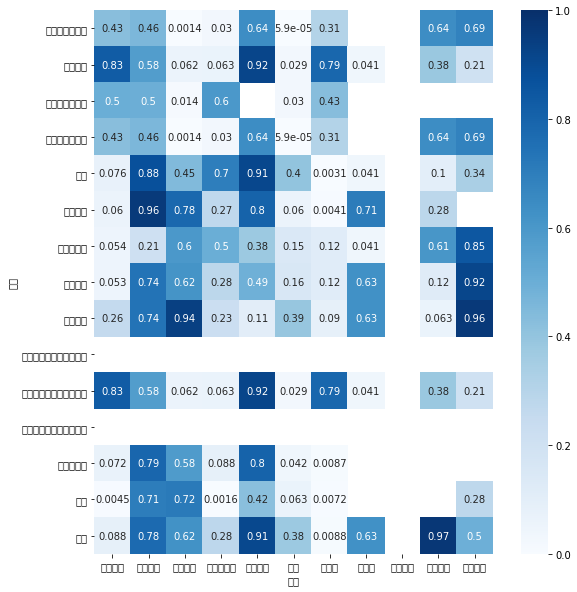

In [34]:
pvalue = result.pivot(index="病症",columns = '因素' , values ='p值')  #交叉表适合排列

plt.subplots(figsize=(10, 10)) # 设置画面大小
sns.heatmap(pvalue, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()